# Model Training

Import data and required packages.

In [1]:
!pip install catboost

  Using cached plotly-6.3.1-py3-none-any.whl.metadata (8.5 kB)
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
    --------------------------------------- 2.1/102.5 MB 10.7 MB/s eta 0:00:10
   - -------------------------------------- 4.5/102.5 MB 10.7 MB/s eta 0:00:10
   -- ------------------------------------- 6.8/102.5 MB 10.8 MB/s eta 0:00:09
   --- ------------------------------------ 9.2/102.5 MB 11.0 MB/s eta 0:00:09
   ---- ----------------------------------- 11.0/102.5 MB 10.7 MB/s eta 0:00:09
   ----- ---------------------------------- 13.1/102.5 MB 10.3 MB/s eta 0:00:09
   ------ --------------------------------- 15.5/102.5 MB 10.5 MB/s eta 0:00:09
   ------ --------------------------------- 17.8/102.5 MB 10.5 MB/s eta 0:00:09
   ------- -------------------------------- 19.9/102.5 MB 10.4 MB/s eta 0:00:08
   -------- ------------------------------- 22.0/102.5 MB 10.4 MB/s eta 0:00:08
   --------- ------------------------------ 23.6/102.5 MB 10.4 MB/s et

In [2]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [3]:
df = pd.read_csv('data/stud.csv')

In [4]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### Create x and y variables from dataframe
x is created by dropping the target column from the dataframe, and y is created by selecting only the target column.

In [6]:
x = df.drop(columns=['math_score'], axis=1)

In [7]:
x.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [8]:
y = df['math_score']

In [9]:
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math_score, Length: 1000, dtype: int64

#### convert categorical columns to numerical using one-hot encoding

Following features are categorical and need to be converted to numerical using one-hot encoding

In [12]:
x.columns

Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course', 'reading_score', 'writing_score'],
      dtype='object')

In [13]:
print("Number of categories in 'gender' : ", df['gender'].unique())
print("Number of categories in 'race_ethnicity' : ", df['race_ethnicity'].unique())
print("Number of categories in 'parental_level_of_education' : ", df['parental_level_of_education'].unique())
print("Number of categories in 'lunch' : ", df['lunch'].unique())
print("Number of categories in 'test_preparation_course' : ", df['test_preparation_course'].unique())

Number of categories in 'gender' :  ['female' 'male']
Number of categories in 'race_ethnicity' :  ['group B' 'group C' 'group A' 'group D' 'group E']
Number of categories in 'parental_level_of_education' :  ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Number of categories in 'lunch' :  ['standard' 'free/reduced']
Number of categories in 'test_preparation_course' :  ['none' 'completed']


In [17]:
num_features = x.select_dtypes(exclude='object').columns
cat_features = x.select_dtypes(include='object').columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

num_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder', oh_transformer, cat_features),
        ('StandardScaler', num_transformer, num_features)
    ]
)

In [18]:
x = preprocessor.fit_transform(x)

In [19]:
x

array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.19399858,  0.39149181],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         1.42747598,  1.31326868],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.77010859,  1.64247471],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.12547206, -0.20107904],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.60515772,  0.58901542],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.15336989,  1.18158627]], shape=(1000, 19))

In [20]:
x.shape

(1000, 19)

In [21]:
## train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [22]:
x_train.shape, x_test.shape

((800, 19), (200, 19))

#### Create evaluation function to evaluate model performance using Mean Absolute Error (MAE) and R-squared (R2) metrics.

In [23]:
def evaluate_model(true, predict):
    mae = mean_absolute_error(true, predict)
    mse = mean_squared_error(true, predict)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, predict)
    return mae, rmse, r2

In [24]:
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Rigid': Ridge(),
    'K-Neighbors Regressor': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(),
    'CatBoosting Regressor': CatBoostRegressor(verbose=False),
    'Adaboost Regressor': AdaBoostRegressor()
}

models_list = []
r2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    models_list.append(list(models.keys())[i])

    print('Model performance for training set')
    print('-> Root mean squared error : {: 4f}'.format(model_train_rmse))
    print('-> Mean absolute error : {: 4f}'.format(model_train_mae))
    print('-> R2 square error : {: 4f}'.format(model_train_r2))

    print('-'*20)

    print('Model performance for test set')
    print('-> Root mean squared error : {: 4f}'.format(model_test_rmse))
    print('-> Mean absolute error : {: 4f}'.format(model_test_mae))
    print('-> R2 square error : {: 4f}'.format(model_test_r2))
    r2_list.append(model_test_r2)

    print('='*30)
    print('\n')


Linear Regression
Model performance for training set
-> Root mean squared error :  5.323051
-> Mean absolute error :  4.266712
-> R2 square error :  0.874317
--------------------
Model performance for test set
-> Root mean squared error :  5.393994
-> Mean absolute error :  4.214763
-> R2 square error :  0.880433


Lasso
Model performance for training set
-> Root mean squared error :  6.593816
-> Mean absolute error :  5.206303
-> R2 square error :  0.807146
--------------------
Model performance for test set
-> Root mean squared error :  6.519695
-> Mean absolute error :  5.157882
-> R2 square error :  0.825320


Rigid
Model performance for training set
-> Root mean squared error :  5.323325
-> Mean absolute error :  4.264988
-> R2 square error :  0.874304
--------------------
Model performance for test set
-> Root mean squared error :  5.390387
-> Mean absolute error :  4.211101
-> R2 square error :  0.880593


K-Neighbors Regressor
Model performance for training set
-> Root mean squ

In [25]:
## Results
pd.DataFrame(list(zip(models_list, r2_list)), columns=['Model Name', 'R2 Score']).sort_values(by=['R2 Score'], ascending=False)

,Model Name,R2 Score
2,Rigid,0.880593
0,Linear Regression,0.880433
5,Random Forest Regressor,0.852786
7,CatBoosting Regressor,0.851632
8,Adaboost Regressor,0.841907
6,XGBRegressor,0.827797
1,Lasso,0.825320
3,K-Neighbors Regressor,0.783813
4,Decision Tree,0.734362


### Linear Regression Model

In [30]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(x_train, y_train)
y_pred = lin_model.predict(x_test)
score = r2_score(y_test, y_pred)
print('Accuracy of the model is %.2f'%score)

Accuracy of the model is 0.88


Text(0, 0.5, 'Predict')

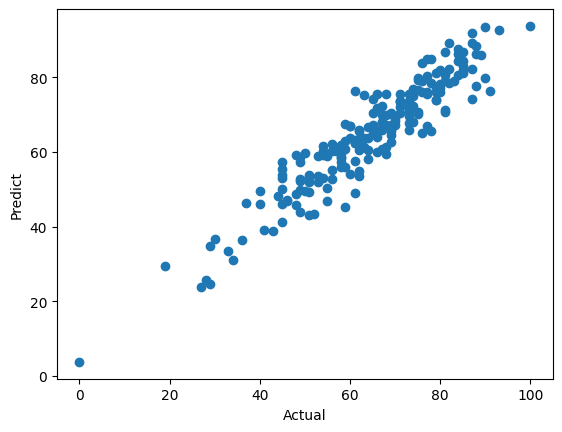

In [31]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predict')

<Axes: xlabel='math_score'>

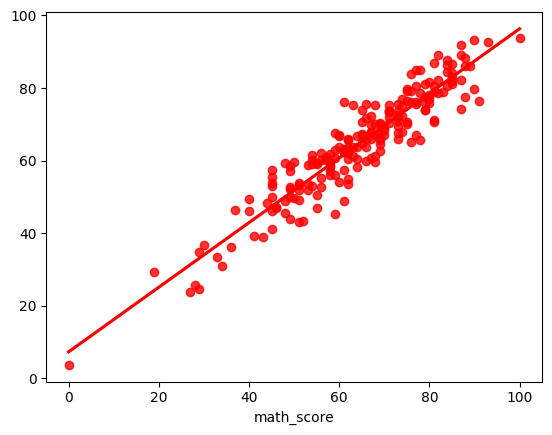

In [35]:
sns.regplot(x=y_test, y=y_pred, ci=None, color='red')

### Difference between Actual and Predicted values visualization

In [37]:
pred_df = pd.DataFrame({'Actual Value':y_test, 'Predicted Value':y_pred, 'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,76.387970,14.612030
737,53,58.885970,-5.885970
740,80,76.990265,3.009735
660,74,76.851804,-2.851804
411,84,87.627378,-3.627378
...,...,...,...
408,52,43.409149,8.590851
332,62,62.152214,-0.152214
208,74,67.888395,6.111605
613,65,67.022287,-2.022287
